# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [2]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += float(loss.detach())

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [64]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [5]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.445
adam: Epoch 4 Loss 0.290
adam: Epoch 6 Loss 0.243
adam: Epoch 8 Loss 0.224
adam: Epoch 10 Loss 0.206
adam: Epoch 12 Loss 0.200
adam: Epoch 14 Loss 0.189
adam: Epoch 16 Loss 0.188
adam: Epoch 18 Loss 0.181
adam: Epoch 20 Loss 0.176


Text(0.5, 1.0, 'MNIST')

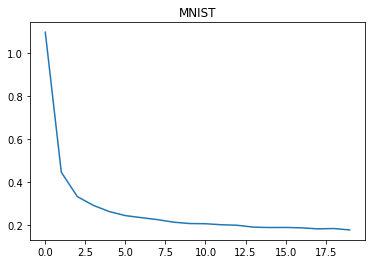

In [6]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [6]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [7]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

NameError: name 'cnnet' is not defined

### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [7]:
def runExperiment(n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer, n_hiddens_per_fc_layer):
    cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
                  patch_size_per_conv_layer, stride_per_conv_layer, device=device)

    n_epochs = 20
    batch_size = 500
    learning_rate = 0.01

    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

    plt.plot(cnnet.error_trace, label='Pytorch')
    plt.title('MNIST')
    plt.show()
    
    return cnnet


def runAll(conv_options, fc_options):
    collected_data = []
    
    for conv_option in conv_options:
        patch = [5]*len(conv_option)
        stride = [1]*len(conv_option)
        print(conv_option, patch, stride, [5])
        cnnet = runExperiment(conv_option, patch, stride, [5])
        
        Classes, _ = cnnet.use(Xtrain)
        perc_correct_train = 100 * np.mean(Classes == Ttrain)

        Classes, _ = cnnet.use(Xtest)
        perc_correct = 100 * np.mean(Classes == Ttest)

        collected_data.append([conv_option,[5],float(perc_correct_train), float(perc_correct)])

        print(f'Test accuracy in percent correct: {perc_correct:.2f}\nConfusion Matrix:')
        print(confusion_matrix(Classes, Ttest))
        
    best_conv_arch = collected_data[np.argmax(collected_data, axis=0)[-1]][0]
    print("The best architecture for convolutional layers was:", best_conv_arch)
    patch = [5]*len(best_conv_arch)
    stride = [1]*len(best_conv_arch)
    
    for fc_option in fc_options:
        print(best_conv_arch, patch, stride, fc_option)
        cnnet = runExperiment(best_conv_arch, patch, stride, fc_option)
        
        Classes, _ = cnnet.use(Xtrain)
        perc_correct_train = 100 * np.mean(Classes == Ttrain)

        Classes, _ = cnnet.use(Xtest)
        perc_correct = 100 * np.mean(Classes == Ttest)

        collected_data.append([best_conv_arch,fc_option,float(perc_correct_train), float(perc_correct)])

        print(f'Test accuracy in percent correct: {perc_correct:.2f}\nConfusion Matrix:')
        print(confusion_matrix(Classes, Ttest))
    
    
    column_names = ["Convolutional Arch", "Fully Connected Arch", "Xtrain % correct", "Xtest % correct"]
    return pandas.DataFrame(collected_data, columns=column_names)

[10] [5] [1] [5]
adam: Epoch 2 Loss 0.746
adam: Epoch 4 Loss 0.588
adam: Epoch 6 Loss 0.540
adam: Epoch 8 Loss 0.479
adam: Epoch 10 Loss 0.458
adam: Epoch 12 Loss 0.437
adam: Epoch 14 Loss 0.421
adam: Epoch 16 Loss 0.411
adam: Epoch 18 Loss 0.400
adam: Epoch 20 Loss 0.393


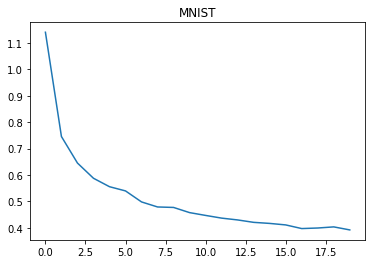

Test accuracy in percent correct: 90.01
Confusion Matrix:
           0          1          2          3          4          5  \
0  97.653061   0.000000   0.000000   0.000000   0.306122   0.306122   
1   0.000000  93.744493   0.088106   1.938326   0.264317   0.176211   
2   4.263566   0.000000  85.077519   3.003876   1.937984   0.000000   
3   0.891089   0.198020   0.693069  87.920792   0.198020   4.257426   
4   0.000000   0.000000   0.203666   0.000000  93.482688   2.342159   
5   1.345291   0.000000   0.000000   0.672646   0.112108  93.721973   
6   1.774530   0.000000   0.208768   0.000000   1.252610   1.356994   
7   0.389105   0.583658   1.167315   1.653696   1.070039   0.097276   
8   2.361396   0.205339   0.205339   2.566735   0.308008   6.673511   
9   0.396432   0.099108   0.000000   0.198216  10.406343   1.982161   

           6          7          8          9  
0   1.326531   0.408163   0.000000   0.000000  
1   0.176211   0.176211   2.466960   0.969163  
2   0.872093   2

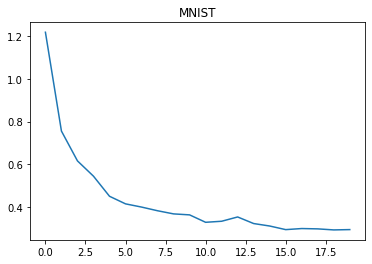

Test accuracy in percent correct: 93.63
Confusion Matrix:
           0          1          2          3          4          5  \
0  96.734694   0.000000   0.306122   0.000000   0.000000   0.000000   
1   0.088106  96.651982   0.264317   0.528634   0.704846   0.264317   
2   0.678295   0.193798  94.961240   0.290698   0.387597   0.096899   
3   0.099010   0.000000   0.693069  92.079208   0.000000   2.376238   
4   0.509165   0.509165   0.000000   0.000000  93.380855   0.610998   
5   0.224215   0.000000   0.000000   2.354260   0.000000  93.834081   
6   1.148225   0.626305   0.313152   0.313152   1.252610   0.208768   
7   0.000000   0.291829   0.875486   1.167315   0.097276   0.097276   
8   5.338809   0.102669   0.102669   0.205339   0.924025   1.642710   
9   0.297324   0.198216   0.099108   0.099108   2.081269   1.486620   

           6          7          8          9  
0   2.346939   0.102041   0.306122   0.204082  
1   0.088106   0.704846   0.704846   0.000000  
2   0.000000   0

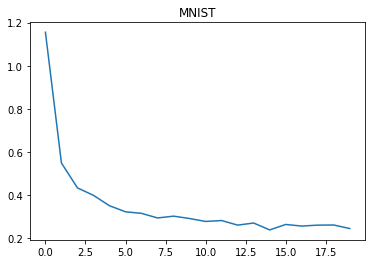

Test accuracy in percent correct: 93.31
Confusion Matrix:
           0          1          2          3          4          5  \
0  97.857143   0.000000   0.204082   0.102041   0.000000   0.816327   
1   0.000000  94.713656   2.907489   1.057269   0.000000   0.088106   
2   0.387597   0.000000  93.798450   1.065891   0.000000   0.968992   
3   0.000000   0.000000   2.871287  93.267327   0.000000   3.366337   
4   0.203666   0.916497   1.731161   0.101833  92.260692   0.101833   
5   0.000000   0.000000   0.224215   1.121076   0.000000  96.860987   
6   1.878914   0.208768   0.208768   0.000000   0.104384   1.670146   
7   0.000000   0.000000   2.237354   6.128405   0.000000   1.070039   
8   1.026694   0.000000   1.642710   0.000000   0.205339   4.312115   
9   0.991080   0.297324   0.000000   2.081269   1.883053   2.973241   

           6          7          8          9  
0   0.306122   0.306122   0.306122   0.102041  
1   0.440529   0.000000   0.792952   0.000000  
2   1.162791   2

/usr/local/python-env/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


adam: Epoch 2 Loss 0.237
adam: Epoch 4 Loss 0.140
adam: Epoch 6 Loss 0.159
adam: Epoch 8 Loss 0.266
adam: Epoch 10 Loss 0.173
adam: Epoch 12 Loss 0.197
adam: Epoch 14 Loss 0.130
adam: Epoch 16 Loss 0.107
adam: Epoch 18 Loss 0.108
adam: Epoch 20 Loss 0.102


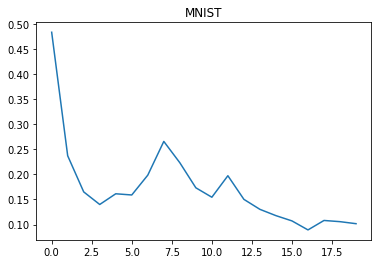

Test accuracy in percent correct: 96.97
Confusion Matrix:
           0          1          2          3          4          5  \
0  97.346939   0.102041   0.306122   0.000000   0.102041   0.102041   
1   0.000000  98.590308   0.000000   0.352423   0.088106   0.000000   
2   0.290698   1.259690  95.930233   0.872093   0.000000   0.000000   
3   0.000000   0.000000   0.297030  97.821782   0.000000   0.198020   
4   0.000000   0.203666   0.101833   0.000000  98.676171   0.000000   
5   0.112108   0.000000   0.112108   1.569507   0.000000  95.291480   
6   0.000000   0.104384   0.000000   0.000000   0.417537   0.208768   
7   0.000000   0.486381   0.778210   0.583658   0.194553   0.000000   
8   0.718686   0.102669   1.232033   0.205339   0.821355   0.513347   
9   0.396432   0.594648   0.396432   0.198216   1.189296   0.099108   

           6          7          8          9  
0   1.632653   0.204082   0.204082   0.000000  
1   0.528634   0.088106   0.352423   0.000000  
2   0.096899   1

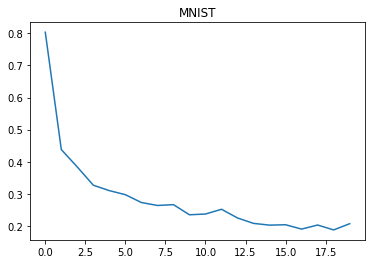

Test accuracy in percent correct: 93.41
Confusion Matrix:
           0          1          2          3          4          5  \
0  96.428571   0.000000   0.102041   0.000000   0.102041   0.102041   
1   0.000000  98.061674   0.440529   0.176211   0.088106   0.000000   
2   0.968992   0.193798  95.251938   0.387597   0.581395   0.000000   
3   0.198020   0.495050   1.881188  92.970297   0.000000   1.584158   
4   0.101833   0.610998   0.101833   0.305499  97.148676   0.101833   
5   0.784753   0.000000   0.112108   1.121076   0.000000  95.403587   
6   1.043841   0.208768   0.104384   0.104384   0.417537   0.313152   
7   0.486381   2.140078   1.945525   1.945525   0.680934   0.486381   
8   0.410678   0.205339   0.821355   0.205339   0.513347   0.718686   
9   0.594648   1.387512   0.099108   0.792864  15.857284   3.072349   

           6          7          8          9  
0   2.040816   0.102041   1.122449   0.000000  
1   0.352423   0.088106   0.792952   0.000000  
2   0.775194   0

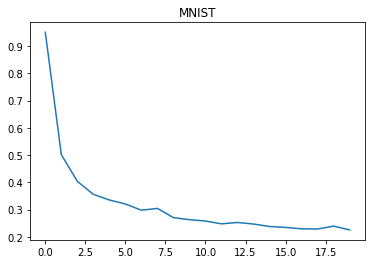

Test accuracy in percent correct: 93.85
Confusion Matrix:
           0          1          2          3          4          5  \
0  95.714286   0.000000   0.102041   0.000000   0.000000   0.306122   
1   0.000000  97.797357   0.352423   0.528634   0.088106   0.000000   
2   0.096899   0.096899  95.542636   0.968992   0.387597   0.193798   
3   0.000000   0.099010   0.990099  95.544554   0.000000   0.693069   
4   0.203666   0.101833   0.305499   0.101833  93.380855   0.000000   
5   1.008969   0.112108   0.000000   5.044843   0.000000  90.919283   
6   0.730689   0.208768   1.565762   0.000000   0.939457   1.774530   
7   0.097276   0.486381   2.334630   1.264591   0.000000   0.194553   
8   0.205339   0.102669   1.437372   1.026694   0.924025   1.745380   
9   0.594648   0.297324   0.594648   2.279485   2.874133   1.288404   

           6          7          8          9  
0   2.755102   0.408163   0.714286   0.000000  
1   0.352423   0.264317   0.616740   0.000000  
2   0.678295   1

In [8]:
resultdf = runAll([[10],[10,10],[10,10,10]], [[],[10],[10,10]])

In [9]:
resultdf

,Convolutional Arch,Fully Connected Arch,Xtrain % correct,Xtest % correct
0,[10],[5],90.632,90.01
1,"[10, 10]",[5],93.052,93.63
2,"[10, 10, 10]",[5],92.798,93.31
3,"[10, 10]",[],98.618,96.97
4,"[10, 10]",[10],93.058,93.41
5,"[10, 10]","[10, 10]",93.686,93.85


### Discussion
This ended up being very interesting. The architectures with 2 and 3 convolutional layers performed very similarly, with the 2 layers being the winner in this case. Other times when I ran while building the functions resulted with the one with 3 layers performing better. Then, when testing the fully connected layer architectures, the one with no fully connected layers was the best, and the other two performed very similar to each other. So the winner was clear. I expect this could be explained by there not being many classes, or the dataset being mostly simple. So the extra complexity of adding more layers was not necessary and actually detrimental.

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [12]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [13]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [14]:
square_pulse = make_square_pulse()
square_pulse

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

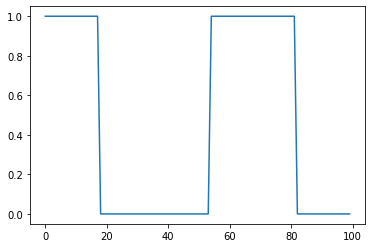

In [15]:
plt.plot(square_pulse)

In [16]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [17]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.14285714, 0.28571429, 0.42857143,
       0.57142857, 0.71428571, 0.85714286, 1.        , 1.        ,
       0.85714286, 0.71428571, 0.57142857, 0.42857143, 0.28571429,
       0.14285714, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.14285714,
       0.28571429, 0.42857143, 0.57142857, 0.71428571, 0.85714286,
       1.        , 1.        , 0.85714286, 0.71428571, 0.57142857,
       0.42857143, 0.28571429, 0.14285714, 0.        , 0.14285

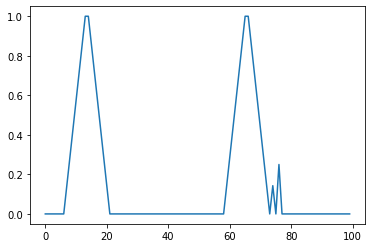

In [18]:
plt.plot(triangular_pulse)

In [19]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [20]:
np.newaxis == None

True

In [21]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [22]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.615
adam: Epoch 20 Loss 0.436
adam: Epoch 30 Loss 0.218
adam: Epoch 40 Loss 0.064
adam: Epoch 50 Loss 0.032
adam: Epoch 60 Loss 0.006
adam: Epoch 70 Loss 0.009
adam: Epoch 80 Loss 0.004
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

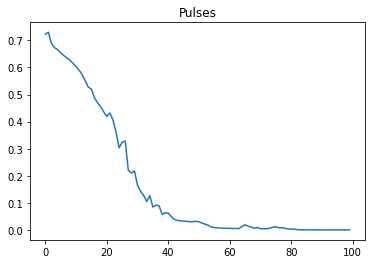

In [23]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [24]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 99.20


,square,triangular
square,98.4,1.6
triangular,0.0,100.0


torch.Size([10, 10])

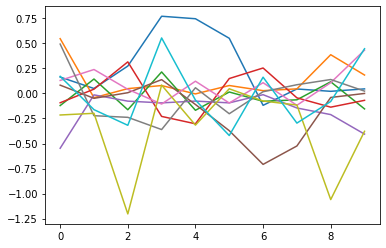

In [25]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [65]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

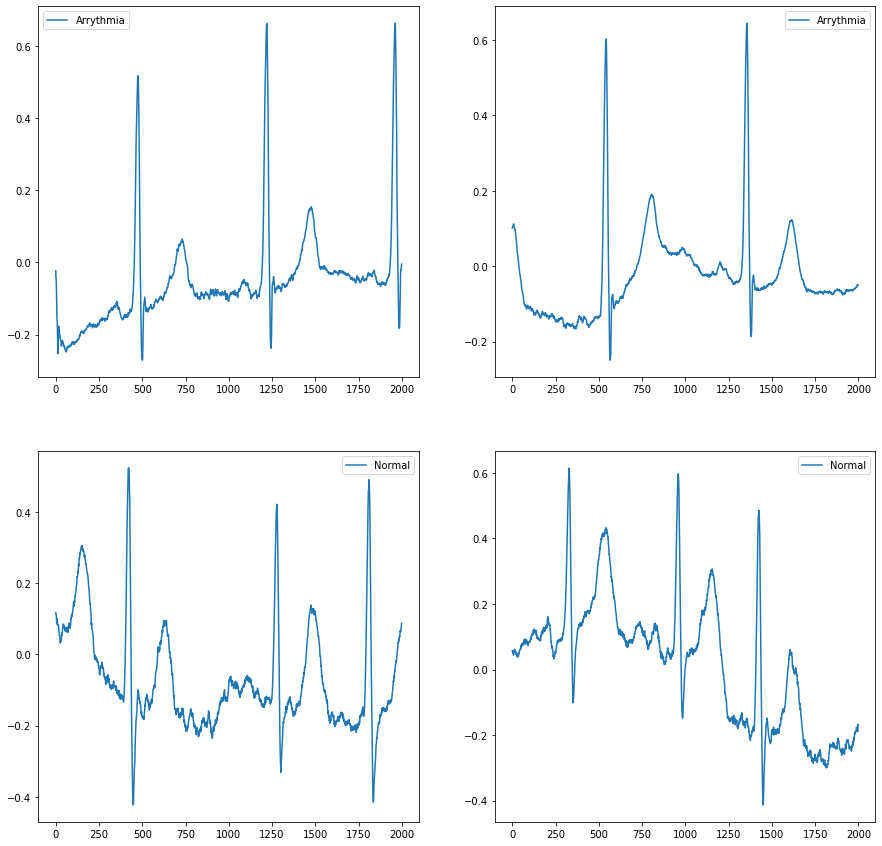

In [66]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [67]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [68]:
Ttrain

array([['nr'],
       ['nr'],
       ['nr'],
       ...,
       ['arr'],
       ['arr'],
       ['nr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [69]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [70]:
def runEcgExperiments(struct_options):
    collected_data = []
    for struct_option in struct_options:
        cnn1d = CNN1D(Xtrain.shape[-1], struct_option[0], struct_option[1], 2, struct_option[2], struct_option[3], device=device)
        n_epochs = 50
        batch_size = 10
        learning_rate = 0.001

        cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
        
        Classes, _ = cnn1d.use(Xtrain)
        perc_correct_train = 100 * np.mean(Classes == Ttrain)

        Classes, _ = cnn1d.use(Xtest)
        perc_correct_test = 100 * np.mean(Classes == Ttest)

        collected_data.append([*struct_option,float(perc_correct_train), float(perc_correct_test)])
    
    column_names = ["Conv Structure", "FC Structure", "Patch Sizes", "Strides", "Train % correct", "Test % correct"]
    return pandas.DataFrame(collected_data, columns=column_names)
                

In [71]:
struct_options = [
    ([5], [20, 10, 5], [1], [1]),
    ([10], [], [100], [20]),
    ([20, 10], [], [100, 20], [20, 5]),
    ([10],[10], [100], [20]),
    ([20, 10], [10], [100, 20], [20, 5]),
    ([10], [20, 10], [100], [20]),
    ([20, 10], [20, 10], [100,20],[20,5]),
    ([10], [20, 10, 5],[100],[20]),
    ([20, 10], [20, 10, 5], [100,20],[20,5]),
    ([20, 10, 5], [20, 10, 5],[100,20,5], [20,5,1]),
]

In [72]:
resultdf = runEcgExperiments(struct_options)

adam: Epoch 5 Loss 0.676
adam: Epoch 10 Loss 0.676
adam: Epoch 15 Loss 0.676
adam: Epoch 20 Loss 0.676
adam: Epoch 25 Loss 0.676
adam: Epoch 30 Loss 0.676
adam: Epoch 35 Loss 0.676
adam: Epoch 40 Loss 0.676
adam: Epoch 45 Loss 0.676
adam: Epoch 50 Loss 0.676
adam: Epoch 5 Loss 0.540
adam: Epoch 10 Loss 0.506
adam: Epoch 15 Loss 0.490
adam: Epoch 20 Loss 0.478
adam: Epoch 25 Loss 0.469
adam: Epoch 30 Loss 0.463
adam: Epoch 35 Loss 0.459
adam: Epoch 40 Loss 0.454
adam: Epoch 45 Loss 0.448
adam: Epoch 50 Loss 0.444
adam: Epoch 5 Loss 0.480
adam: Epoch 10 Loss 0.246
adam: Epoch 15 Loss 0.134
adam: Epoch 20 Loss 0.087
adam: Epoch 25 Loss 0.065
adam: Epoch 30 Loss 0.054
adam: Epoch 35 Loss 0.055
adam: Epoch 40 Loss 0.028
adam: Epoch 45 Loss 0.027
adam: Epoch 50 Loss 0.032
adam: Epoch 5 Loss 0.491
adam: Epoch 10 Loss 0.336
adam: Epoch 15 Loss 0.247
adam: Epoch 20 Loss 0.220
adam: Epoch 25 Loss 0.166
adam: Epoch 30 Loss 0.147
adam: Epoch 35 Loss 0.137
adam: Epoch 40 Loss 0.099
adam: Epoch 45 L

In [73]:
resultdf

,Conv Structure,FC Structure,Patch Sizes,Strides,Train % correct,Test % correct
0,[5],"[20, 10, 5]",[1],[1],59.257732,62.654575
1,[10],[],[100],[20],75.381443,71.723001
2,"[20, 10]",[],"[100, 20]","[20, 5]",98.865979,93.487222
3,[10],[10],[100],[20],92.103093,73.619126
4,"[20, 10]",[10],"[100, 20]","[20, 5]",99.958763,93.816983
5,[10],"[20, 10]",[100],[20],96.659794,76.422094
6,"[20, 10]","[20, 10]","[100, 20]","[20, 5]",96.597938,87.716406
7,[10],"[20, 10, 5]",[100],[20],96.824742,76.586974
8,"[20, 10]","[20, 10, 5]","[100, 20]","[20, 5]",99.670103,91.591096
9,"[20, 10, 5]","[20, 10, 5]","[100, 20, 5]","[20, 5, 1]",99.608247,95.383347


### Discussion
My results show that increasing the number of convolutional layers or fully connected layers will improve the training accuracy, but increasing the test accuracy usually depends mostly on increasing the number of convolutional layers. This could possibly be improved as well by increasing the number of epochs. It also seems that higher patch sizes improves the overall accuracy. The best performing architecture was the bottom row, which had the highest number of layers for both convolutional and fully connected. This had a near perfect train accuracy and a very satisfying 95% for test accuracy. This is also one of the few architectures that I tried that had a stride of 1 for one of the layers. The affect of the stride would be something to explore further in the futre.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [49]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Oleary-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.